In [387]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score

In [388]:
train = pd.read_csv('Train.csv')
train.head()

,ambient_temperature,environmental_quality,sound_intensity_db,illumination_level,people_density,hour,day_of_week,humidity_percent
0,22.003822,28.079517,60.092042,277.643822,23.906759,19,4,48.134389
1,20.984082,52.007786,62.277048,201.781610,7.087828,12,5,37.431508
2,26.872562,127.069727,54.212822,341.686722,6.005155,6,4,79.016310
3,22.290611,137.996745,50.646878,255.993168,35.026450,7,6,58.370442
4,18.914945,68.976448,48.911256,352.588756,57.080672,13,3,57.040981


In [389]:
train.shape

(24800, 8)

In [390]:
train.isnull().sum()

ambient_temperature      0
environmental_quality    0
sound_intensity_db       0
illumination_level       0
people_density           0
hour                     0
day_of_week              0
humidity_percent         0
dtype: int64

In [391]:
train.duplicated().sum()

0

In [392]:
test = pd.read_csv('Test.csv')
test.head()

,ambient_temperature,environmental_quality,sound_intensity_db,illumination_level,people_density,hour,day_of_week,humidity_percent
0,23.589244,89.905603,60.650242,286.681242,42.015551,10,4,NaN
1,29.637104,73.033123,49.973415,263.818471,47.004769,19,5,NaN
2,23.925204,108.051959,40.993816,316.150700,31.992572,18,6,NaN
3,21.034768,133.010500,55.320404,276.626680,56.115662,6,6,NaN
4,20.621485,72.946342,56.323421,362.454543,20.008668,15,5,NaN


In [393]:
test.shape

(196, 8)

In [394]:
test.isnull().sum()

ambient_temperature        0
environmental_quality      0
sound_intensity_db         0
illumination_level         0
people_density             0
hour                       0
day_of_week                0
humidity_percent         196
dtype: int64

In [395]:
test.duplicated().sum()

0

In [396]:
combined = pd.concat([train, test], axis = 0)
combined.shape

(24996, 8)

In [397]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24996 entries, 0 to 195
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ambient_temperature    24996 non-null  float64
 1   environmental_quality  24996 non-null  float64
 2   sound_intensity_db     24996 non-null  float64
 3   illumination_level     24996 non-null  float64
 4   people_density         24996 non-null  float64
 5   hour                   24996 non-null  int64  
 6   day_of_week            24996 non-null  int64  
 7   humidity_percent       24800 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 1.7 MB


In [398]:
combined['temperature_x_density'] = combined['ambient_temperature'] * combined['people_density']

In [399]:
combined['sound_temp_ratio'] = combined['sound_intensity_db'] / (combined['ambient_temperature'] + 1)

In [400]:
combined['illumination_density'] = combined['illumination_level'] / (combined['people_density'] + 1)

In [401]:
combined['hour_sin'] = np.sin(2 * np.pi * combined['hour'] / 24)
combined['hour_cos'] = np.cos(2 * np.pi * combined['hour'] / 24)

In [402]:
combined['is_weekend'] = combined['day_of_week'].isin([0, 6]).astype(int)
combined['day_type'] = combined['day_of_week'].apply(lambda x: 'weekend' if x in [0, 6] else 'weekday')

In [403]:
combined['ambient_temperature'].min(), combined['ambient_temperature'].max()

(15.16589212, 33.63241613)

In [404]:
combined['people_density'].min(), combined['people_density'].max()

(4.845046508, 59.16274552)

In [405]:
combined['temp_bin'] = pd.cut(combined['ambient_temperature'], bins=[15, 22, 28, 34], labels=['low', 'moderate', 'high'], include_lowest=True)

In [406]:
combined['density_level'] = pd.cut(combined['people_density'], bins=[4, 20, 40, 60], labels=['low', 'medium', 'high'], include_lowest=True)

In [407]:
combined['ventilation_index'] = (combined['sound_intensity_db'] * combined['illumination_level']) / (combined['people_density'] + 1)

In [408]:
combined.head()

,ambient_temperature,environmental_quality,sound_intensity_db,illumination_level,people_density,hour,day_of_week,humidity_percent,temperature_x_density,sound_temp_ratio,illumination_density,hour_sin,hour_cos,is_weekend,day_type,temp_bin,density_level,ventilation_index
0,22.003822,28.079517,60.092042,277.643822,23.906759,19,4,48.134389,526.040068,2.612263,11.147329,-9.659258e-01,2.588190e-01,0,weekday,moderate,medium,669.865737
1,20.984082,52.007786,62.277048,201.781610,7.087828,12,5,37.431508,148.731558,2.832825,24.948802,1.224647e-16,-1.000000e+00,0,weekday,low,low,1553.737748
2,26.872562,127.069727,54.212822,341.686722,6.005155,6,4,79.016310,161.373906,1.945025,48.776467,1.000000e+00,6.123234e-17,0,weekday,moderate,low,2644.309899
3,22.290611,137.996745,50.646878,255.993168,35.026450,7,6,58.370442,780.760977,2.174562,7.105701,9.659258e-01,-2.588190e-01,1,weekend,moderate,medium,359.881545
4,18.914945,68.976448,48.911256,352.588756,57.080672,13,3,57.040981,1079.677770,2.456008,6.070673,-2.588190e-01,-9.659258e-01,0,weekday,low,high,296.924229


In [409]:
input_variables = combined[['ambient_temperature', 'environmental_quality', 'sound_intensity_db', 'illumination_level', 'people_density',
                           'temperature_x_density', 'sound_temp_ratio', 'illumination_density', 'ventilation_index']]

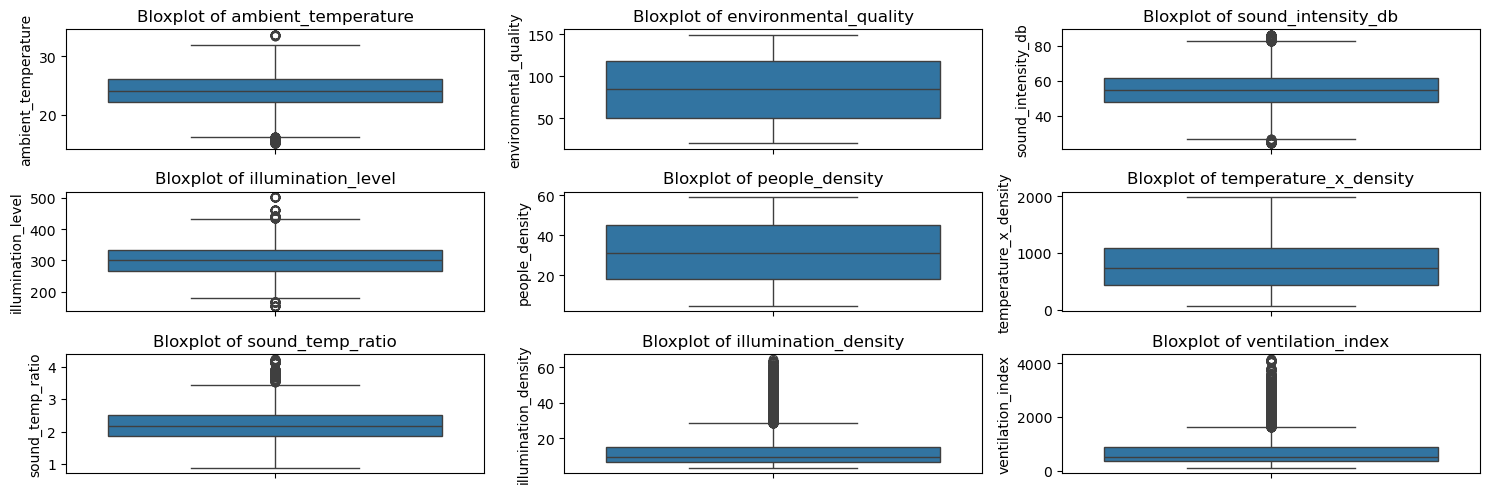

In [410]:
fig, axes = plt.subplots(3, 3, figsize=(15,5))
axes = axes.flatten()

for i, col in enumerate(input_variables.columns):
    sns.boxplot(data = combined, y=col, ax=axes[i])
    axes[i].set_title(f'Bloxplot of {col}')

plt.tight_layout()
plt.show()

In [411]:
def replace_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    lower = q1-1.5*iqr
    upper = q3+1.5*iqr
    median_value = df[column].median()
    df[column] = np.where((df[column]<lower)|(df[column]>upper), median_value, df[column])
    return df

In [412]:
for col in input_variables.columns:
    concat_df = replace_outliers(combined, col)

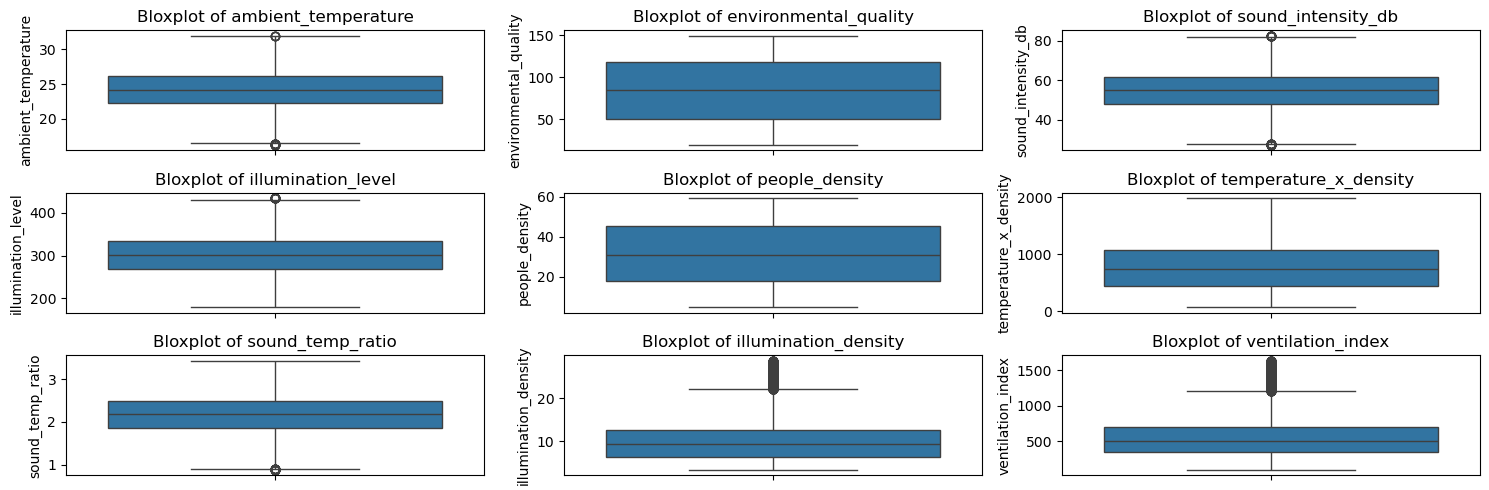

In [413]:
fig, axes = plt.subplots(3, 3, figsize=(15,5))
axes = axes.flatten()

for i, col in enumerate(input_variables.columns):
    sns.boxplot(data = combined, y=col, ax=axes[i])
    axes[i].set_title(f'Bloxplot of {col}')

plt.tight_layout()
plt.show()

In [414]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24996 entries, 0 to 195
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   ambient_temperature    24996 non-null  float64 
 1   environmental_quality  24996 non-null  float64 
 2   sound_intensity_db     24996 non-null  float64 
 3   illumination_level     24996 non-null  float64 
 4   people_density         24996 non-null  float64 
 5   hour                   24996 non-null  int64   
 6   day_of_week            24996 non-null  int64   
 7   humidity_percent       24800 non-null  float64 
 8   temperature_x_density  24996 non-null  float64 
 9   sound_temp_ratio       24996 non-null  float64 
 10  illumination_density   24996 non-null  float64 
 11  hour_sin               24996 non-null  float64 
 12  hour_cos               24996 non-null  float64 
 13  is_weekend             24996 non-null  int32   
 14  day_type               24996 non-null  object

In [415]:
combined = combined.drop(['hour', 'day_of_week', 'day_type'], axis = 1)
combined.shape

(24996, 15)

In [416]:
le = LabelEncoder()
x = ['temp_bin', 'density_level']
for i in x:
    combined[i] = le.fit_transform(combined[i])

In [417]:
combined.head()

,ambient_temperature,environmental_quality,sound_intensity_db,illumination_level,people_density,humidity_percent,temperature_x_density,sound_temp_ratio,illumination_density,hour_sin,hour_cos,is_weekend,temp_bin,density_level,ventilation_index
0,22.003822,28.079517,60.092042,277.643822,23.906759,48.134389,526.040068,2.612263,11.147329,-9.659258e-01,2.588190e-01,0,2,2,669.865737
1,20.984082,52.007786,62.277048,201.781610,7.087828,37.431508,148.731558,2.832825,24.948802,1.224647e-16,-1.000000e+00,0,1,1,1553.737748
2,26.872562,127.069727,54.212822,341.686722,6.005155,79.016310,161.373906,1.945025,9.423192,1.000000e+00,6.123234e-17,0,2,1,505.298053
3,22.290611,137.996745,50.646878,255.993168,35.026450,58.370442,780.760977,2.174562,7.105701,9.659258e-01,-2.588190e-01,1,2,2,359.881545
4,18.914945,68.976448,48.911256,352.588756,57.080672,57.040981,1079.677770,2.456008,6.070673,-2.588190e-01,-9.659258e-01,0,1,0,296.924229


In [418]:
newtrain = combined.iloc[0:24800, :]
newtest = combined.iloc[24800:, : ]
newtest = newtest.drop('humidity_percent', axis = 1)

In [419]:
newtrain.shape

(24800, 15)

In [420]:
newtest.shape

(196, 14)

In [482]:
x = newtrain.drop('humidity_percent', axis = 1)
y = newtrain['humidity_percent']

In [484]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [486]:
models = {'Logistic Regression': LinearRegression(), 'Random Forest': RandomForestRegressor(),
         'Bagging': BaggingRegressor(), 'Extra Tree': ExtraTreesRegressor(), 'LightGBM': LGBMRegressor(),
         'Gradient Boosting': GradientBoostingRegressor(), 'Adaboost': AdaBoostRegressor(), 'CatBoost': CatBoostRegressor()}

In [488]:
def evaluate_models(x_train, x_test, y_train, y_test, models):
    results = {}
    for name, model in models.items():
        cv_rmse = -cross_val_score(model, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
        results[name] = cv_rmse
    return results  

In [490]:
results = evaluate_models(x_train, x_test, y_train, y_test, models)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2342
[LightGBM] [Info] Number of data points in the train set: 15872, number of used features: 14
[LightGBM] [Info] Start training from score 60.236479
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2342
[LightGBM] [Info] Number of data points in the train set: 15872, number of used features: 14
[LightGBM] [Info] Start training from score 60.297965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2342
[LightGBM] [Info] Number of data points in the train s

In [493]:
best_model_name = min(results, key = results.get)
best_model = models[best_model_name]

In [494]:
print(f"best model is {best_model_name} with rmse {results[best_model_name]}")

best model is Extra Tree with rmse 0.13265544820054198


In [499]:
y_pred = best_model.fit(x_train, y_train).predict(x_test)

In [500]:
print(np.sqrt(mean_squared_error(y_test, y_pred)))


0.10463124736265421


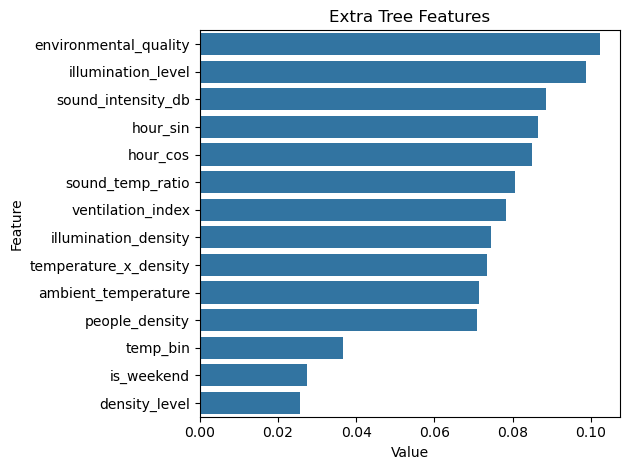

In [503]:
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_, x.columns), reverse=True)[:20], columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title(f'{best_model_name} Features')
plt.tight_layout()
plt.show()

In [505]:
x_train = newtrain.drop('humidity_percent', axis = 1)
y_train = newtrain['humidity_percent']
x_test = newtest
y_pred = best_model.fit(x_train, y_train).predict(x_test)

In [511]:
rf = RandomForestRegressor()
x_train = newtrain.drop('humidity_percent', axis = 1)
y_train = newtrain['humidity_percent']
x_test = newtest
y_pred = rf.fit(x_train, y_train).predict(x_test)
solution = pd.DataFrame({'humidity_percent': y_pred})
solution.head()

,humidity_percent
0,72.806404
1,64.180977
2,61.526823
3,63.440251
4,64.844031


In [512]:
solution.to_csv('RF.csv', index = False)